In [1]:
import os
import sys
# 1. 현재 작업 디렉토리(CWD)를 부모 폴더(프로젝트 루트)로 변경
# (현재 위치가 'models' 폴더일 경우에만 실행하도록 안전장치 추가)
if os.path.basename(os.getcwd()) == 'models':
    os.chdir('..')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

# 데이터 처리
import pandas as pd
import numpy as np
import math
import os
from tqdm import tqdm
import easydict
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 프로젝트 모듈 (기존 .py 파일들)
from dataset import create_dataloaders, collate_fn
from utils import hist_conversations_length, augment_csv_to_file
from preprocessing import preprocess_sentence

# 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f'Using device: {device}')

# 재현성을 위한 시드 설정
torch.manual_seed(42)
if torch.backends.mps.is_available():
    pass
    # torch.backends.mps.manual_seed_all(42)
np.random.seed(42)

Using device: cuda


In [2]:
TRAIN_PATH = "./Data/aiffel-dl-thon-dktc-online-15/train.csv"
TEST_PATH = "./Data/aiffel-dl-thon-dktc-online-15/test.csv"
SUBMIT_PATH = "./Data/aiffel-dl-thon-dktc-online-15/submission.csv"
AUGMENTED_TRAIN_PATH = "./Data/aiffel-dl-thon-dktc-online-15/augmented_train.csv"
BEST_MODEL_PATH = "./models/best_model_classification_only.pt"

# 1. 모델 정의

In [3]:
class MultiHeadAttention(nn.Module):
    """GPT-1 스타일 Causal Multi-Head Self-Attention"""
    
    def __init__(self, emb_dim, num_heads, dropout=0.1, bias=False):
        super().__init__()
        assert emb_dim % num_heads == 0
        
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, emb_dim = x.shape
        
        # Q, K, V projections
        Q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Causal mask (미래 토큰 참조 방지)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(causal_mask, float('-inf'))
        
        # Softmax & dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, emb_dim)
        
        return self.out_proj(attn_output)

In [4]:
class PositionWiseFeedForward(nn.Module):
    """Position-wise FFN with GELU activation"""
    
    def __init__(self, emb_dim, ffn_dim, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, ffn_dim)
        self.w_2 = nn.Linear(ffn_dim, emb_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))


class PositionalEmbedding(nn.Embedding):
    """Learned Positional Embedding (GPT-1 style)"""
    
    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim, padding_idx=padding_idx)
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        positions = positions.unsqueeze(0).expand(batch_size, -1)
        return super().forward(positions)

In [5]:
class DecoderLayer(nn.Module):
    """GPT-1 Decoder Layer (Pre-LN)"""
    
    def __init__(self, config):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(
            emb_dim=config.emb_dim,
            num_heads=config.num_heads,
            dropout=config.dropout,
            bias=False
        )
        
        self.ffn = PositionWiseFeedForward(
            emb_dim=config.emb_dim,
            ffn_dim=config.ffn_dim,
            dropout=config.dropout
        )
        
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x, mask=None):
        # Pre-LN: Norm -> Attention -> Residual
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x, mask=mask)
        x = self.dropout(x)
        x = residual + x
        
        # Pre-LN: Norm -> FFN -> Residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = residual + x
        
        return x


class Decoder(nn.Module):
    """GPT-1 Decoder"""
    
    def __init__(self, config, embedding_layer):
        super().__init__()
        
        self.embed_tokens = embedding_layer
        self.embed_positions = PositionalEmbedding(
            num_positions=config.max_seq_len,
            embedding_dim=config.emb_dim,
            padding_idx=config.pad_idx
        )
        
        self.layers = nn.ModuleList([
            DecoderLayer(config) for _ in range(config.num_layers)
        ])
        
        self.final_norm = nn.LayerNorm(config.emb_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, input_ids, mask=None):
        x = self.embed_tokens(input_ids)
        x = x + self.embed_positions(input_ids)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, mask=mask)
        
        x = self.final_norm(x)
        return x

### ⚡ **CRITICAL CHANGE: CLASSIFICATION ONLY**

#### What Changed:
1. **REMOVED**: Language Modeling Head (`prediction_head`)
2. **REMOVED**: Weight tying with embeddings
3. **SIMPLIFIED**: Model only returns classification logits
4. **REMOVED**: Text generation function

#### Why This Helps:
- ✅ **100% focus on classification** (no LM distraction)
- ✅ **Faster training** (fewer parameters)
- ✅ **Simpler loss** (no multi-task balancing)
- ✅ **Better accuracy** (expected 70-75%+)

In [6]:
class GPT1Classifier(nn.Module):
    """GPT-1 + Text Classification (CLASSIFICATION ONLY - NO LANGUAGE MODELING)"""
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Shared token embedding
        self.dec_embedding = nn.Embedding(
            config.vocab_size,
            config.emb_dim,
            padding_idx=config.pad_idx
        )
        
        # GPT-1 Decoder
        self.decoder = Decoder(config, self.dec_embedding)
        
        # ⚡ CHANGE: ONLY Classification Head (NO Language Modeling Head)
        self.classification_head = nn.Sequential(
            nn.Dropout(0.3),  # Higher dropout for regularization
            nn.Linear(config.emb_dim, config.emb_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(config.emb_dim, config.num_classes)
        )
        
    def forward(self, input_ids):
        # Decoder
        hidden_states = self.decoder(input_ids)
        
        # ⚡ CHANGE: ONLY return classification logits
        # Use LAST token (causal mask compatible)
        cls_hidden = hidden_states[:, -1, :]  
        # cls_hidden, _ = torch.max(hidden_states, dim=1)
        # cls_logits = self.classification_head(cls_hidden)
        # cls_hidden = hidden_states.mean(dim=1) 
        cls_logits = self.classification_head(cls_hidden)
        
        return cls_logits  # ⚡ ONLY classification logits (no LM logits)

# 2. Helper
- Augementation 진행

In [7]:
augment_csv_to_file(
    input_path=TRAIN_PATH,
    output_path=AUGMENTED_TRAIN_PATH,
    augment_ratio=2,              # 원본의 n배 증강 추가
    dropout_rate=0.15,
    exclude_labels=["일반 대화"],  # '일반 대화'는 증강 제외
    min_tokens_after=5,
    seed=42,
)

,idx,class,conversation
0,0,갈취 대화,야 너 휴대폰좀 빌려줘봐\n안돼. 지난달에도 휴대폰 요금이 너무 많이 나와서 엄마한...
1,1,기타 괴롭힘 대화,이거 할인 된다면서요\n 확인해보겠습니다\n 아까 저 시람은 할인 해주던데\n 네 ...
2,2,기타 괴롭힘 대화,너 세수는 했냐?\n세수 했는데.\n했는데도 그 모양이면 말고 다녀라\n얼굴에 잔뜩...
3,3,갈취 대화,야.!! 빵셔틀 1\n빵셔틀 1 김빵맨.\n지금 시간 10분. 지금 당장 매점으로 ...
4,4,갈취 대화,내일 학교올때 십만원 가져와\n이제 더이상 구할데가없어\n너네 부모님에게 부탁해\n...
...,...,...,...
12845,12845,직장 내 괴롭힘 대화,빨리빨리 일 처리 안해?\n죄송합니다\n김대리 짤리고 싶어?\n죄송합니다 빨리 시정...
12846,12846,협박 대화,어디냐?\n왜?\n쌀쌀맞긴 이혼소송 도중에 연락해서 좀 그런데 내 짐 좀 가져가려 ...
12847,12847,협박 대화,이거 해줘\n내가 왜?\n해달라니깐\n너일이잖아\n너가 더잘하잖아 해줘\n내가 잘하...
12848,12848,기타 괴롭힘 대화,나 우울해 .\n약 잘 챙겨먹고있어? 오늘 왜\n그냥 다 힘드네 죽고싶다.\n하 ....


# 3. train 함수

In [8]:
def train_epoch(model, train_loader, optimizer, criterion, scheduler, device, epoch):
    """한 에폭 학습 (CLASSIFICATION ONLY)"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # ⚡ CHANGE: Model only returns cls_logits (no lm_logits)
        cls_logits = model(input_ids)
        
        # ⚡ CHANGE: Only classification loss (no LM loss)
        loss = criterion(cls_logits, labels)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        _, predicted = torch.max(cls_logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })
    
    return total_loss / len(train_loader), 100 * correct / total


def validate_epoch(model, val_loader, criterion, device, epoch):
    """검증 (CLASSIFICATION ONLY)"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation {epoch}"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            # ⚡ CHANGE: Model only returns cls_logits
            cls_logits = model(input_ids)
            
            # ⚡ CHANGE: Only classification loss
            loss = criterion(cls_logits, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(cls_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(val_loader), 100 * correct / total

# 4. 하이퍼파라미터 설정

In [ ]:
VALIDATION_SPLIT = 0.1

VOCAB_SIZE = 1300
MAX_LENGTH = 400
BATCH_SIZE = 32
EMBEDDING_DIM = 64
FFN_DIM = 256
NUM_HEADS = 2
NUM_LAYERS = 1
NUM_CLASSES = 5
DROPOUT = 0.5

NUM_EPOCHS = 500
PATIENCE = 20

# 5. 데이터 로더 생성

In [10]:
# 데이터로더 생성 (기존 함수 사용)
print("\n" + "="*50)
print("Creating DataLoaders using existing scripts...")
print("="*50)

train_loader, val_loader, test_loader, vocab = create_dataloaders(
    AUGMENTED_TRAIN_PATH, 
    TEST_PATH, 
    vocab_size=VOCAB_SIZE,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
)

print(f"\n✓ DataLoaders created successfully!")
print(f"  Vocabulary size: {len(vocab)}")
print(f"  Max sequence length: {MAX_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")


Creating DataLoaders using existing scripts...
데이터 로드 및 전처리 중...
Train 데이터: 12850 개의 conversation
Test 데이터: 500 개의 conversation



샘플 데이터:
Conversation: 야 너 휴대폰좀 빌려줘봐 안돼. 지난달에도 휴대폰 요금이 너무 많이 나와서 엄마한테 혼났어. 알 바야? 닥치고 폰이나 내놔 폰 주면 또 결제하려고 그러지? 응 게임 캐시 다떨어져서 충전좀 안돼 진짜. 맞고 줄래 그냥 줄래? 진짜 한번만 더 결제한거 들켰다가는 휴대폰 뺏길지도 몰라 아 씨 오늘따라 왜이렇게 말이 당장? 제발.
Label: 1

Conversation: 이거 할인 된다면서요 확인해보겠습니다 아까 저 시람은 할인 해주던데 네 저 손님은 고객님이십니다 고객을 차별하는 거에요? 저희는 등급제로 운영돼서 그런겁니다 점장 불러오세요 손님 이건 점장님도 해결해주시지 못합니다 그니까 점장 불러와 진정을 좀 해보세요
Label: 3

Conversation: 너 세수는 했냐? 세수 했는데. 했는데도 그 모양이면 말고 다녀라 얼굴에 잔뜩 여드름 꽃 핀거 봐 우웩. 더러워서 보기도 싫다 아유 냄새도 나는거 같아 그 얼굴로 다니면 안 챙피하냐? 너희들이 나 놀리는거잖아! 놀리기는 있는 그대로 얘기 하는건데 자꾸 그러지마
Label: 3

SentencePiece 모델 학습 중...

모델 저장됨: ./configs/sentences.model
Vocab 크기: 1300

Train DataLoader 준비 완료: 총 11565개 conversations
Validation DataLoader 준비 완료: 총 1285개 conversations
Test DataLoader 준비 완료: 총 500개 conversations.

✓ DataLoaders created successfully!
  Vocabulary size: 1300
  Max sequence length: 400
  Batch size: 32
  Train batches: 362
  Test batches: 16


# 6. 모델 선언

In [11]:
# 모델 설정
config = easydict.EasyDict({
    "vocab_size": len(vocab),
    "pad_idx": vocab.PAD_ID,
    "eos_idx": vocab.EOS_ID,
    "cls_idx": vocab.CLS_ID,
    "emb_dim": EMBEDDING_DIM,
    "ffn_dim": FFN_DIM,
    "num_heads": NUM_HEADS,
    "num_layers": NUM_LAYERS,
    "max_seq_len": MAX_LENGTH,
    "num_classes": NUM_CLASSES,
    "dropout": DROPOUT,
})

# ⚡ CHANGE: Use GPT1Classifier (no LM head)
model = GPT1Classifier(config).to(device)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*60}")
print(f"Model Configuration (CLASSIFICATION ONLY)")
print(f"{'='*60}")
for key, value in config.items():
    print(f"  {key:20s}: {value}")
print(f"\n  {'Total Parameters':20s}: {total_params:,}")
print(f"{'='*60}\n")

print("⚡ Changes from original:")
print("  - Removed Language Modeling Head")
print("  - Classification-only model")
print("  - Expect faster convergence & better accuracy!")


Model Configuration (CLASSIFICATION ONLY)
  vocab_size          : 1300
  pad_idx             : 0
  eos_idx             : 3
  cls_idx             : 4
  emb_dim             : 64
  ffn_dim             : 256
  num_heads           : 2
  num_layers          : 1
  max_seq_len         : 400
  num_classes         : 5
  dropout             : 0.5

  Total Parameters    : 163,141

⚡ Changes from original:
  - Removed Language Modeling Head
  - Classification-only model
  - Expect faster convergence & better accuracy!


# 7. loss function, optimizer 정의

In [12]:
# ⚡ CHANGE: Simple Classification Loss (NO Multi-task)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,  # Slightly higher LR since no LM task
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=0.05  # L2 regularization
)

# Learning Rate Scheduler
def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

warmup_steps = 500
total_steps = len(train_loader) * 30
scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print(f"✓ Training setup complete! (CLASSIFICATION ONLY)")
print(f"  Loss: CrossEntropyLoss (no multi-task)")
print(f"  Initial LR: {optimizer.param_groups[0]['lr']}")
print(f"  Warmup steps: {warmup_steps}, Total steps: {total_steps}")

✓ Training setup complete! (CLASSIFICATION ONLY)
  Loss: CrossEntropyLoss (no multi-task)
  Initial LR: 0.0
  Warmup steps: 500, Total steps: 10860


# 8. 모델 훈련

In [13]:
best_val_loss = float('inf')
patience_counter = 0

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print("\n" + "="*60)
print("Start Training (CLASSIFICATION ONLY - NO LM)")
print("="*60 + "\n")

for epoch in range(1, NUM_EPOCHS + 1):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, scheduler, device, epoch
    )
    
    # Validate
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, device, epoch
    )
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # ⚡ Check overfitting gap
    gap = train_acc - val_acc
    if gap > 15:
        print(f"  ⚠️  WARNING: Overfitting gap = {gap:.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, BEST_MODEL_PATH)
        print(f"  ✓ Model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
        
        if patience_counter >= PATIENCE:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch}")
            break
    
    print("-" * 60)

print("\n" + "="*60)
print("Training Complete!")
print("="*60)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Acc: {max(history['val_acc']):.2f}%")


Start Training (CLASSIFICATION ONLY - NO LM)



Validation 1: 100%|██████████| 41/41 [00:00<00:00, 230.54it/s]



Epoch 1/200:
  Train - Loss: 1.5950, Acc: 23.48%
  Val   - Loss: 1.5765, Acc: 24.82%
  ✓ Model saved! (Val Loss: 1.5765)
------------------------------------------------------------


Validation 2: 100%|██████████| 41/41 [00:00<00:00, 228.90it/s]



Epoch 2/200:
  Train - Loss: 1.5770, Acc: 23.92%
  Val   - Loss: 1.5937, Acc: 24.90%
  No improvement (1/20)
------------------------------------------------------------


Validation 3: 100%|██████████| 41/41 [00:00<00:00, 221.77it/s]



Epoch 3/200:
  Train - Loss: 1.5427, Acc: 27.17%
  Val   - Loss: 1.9279, Acc: 13.46%
  No improvement (2/20)
------------------------------------------------------------


Validation 4: 100%|██████████| 41/41 [00:00<00:00, 197.83it/s]



Epoch 4/200:
  Train - Loss: 1.5174, Acc: 29.49%
  Val   - Loss: 2.0049, Acc: 21.87%
  No improvement (3/20)
------------------------------------------------------------


Validation 5: 100%|██████████| 41/41 [00:00<00:00, 223.18it/s]



Epoch 5/200:
  Train - Loss: 1.5067, Acc: 29.83%
  Val   - Loss: 1.8079, Acc: 24.51%
  No improvement (4/20)
------------------------------------------------------------


Validation 6: 100%|██████████| 41/41 [00:00<00:00, 223.85it/s]



Epoch 6/200:
  Train - Loss: 1.4951, Acc: 30.96%
  Val   - Loss: 1.7033, Acc: 31.60%
  No improvement (5/20)
------------------------------------------------------------


Validation 7: 100%|██████████| 41/41 [00:00<00:00, 223.18it/s]



Epoch 7/200:
  Train - Loss: 1.4829, Acc: 31.56%
  Val   - Loss: 1.6281, Acc: 31.83%
  No improvement (6/20)
------------------------------------------------------------


Validation 8: 100%|██████████| 41/41 [00:00<00:00, 225.84it/s]



Epoch 8/200:
  Train - Loss: 1.4745, Acc: 31.76%
  Val   - Loss: 1.5124, Acc: 32.22%
  ✓ Model saved! (Val Loss: 1.5124)
------------------------------------------------------------


Validation 9: 100%|██████████| 41/41 [00:00<00:00, 223.59it/s]



Epoch 9/200:
  Train - Loss: 1.4662, Acc: 32.18%
  Val   - Loss: 1.4985, Acc: 32.06%
  ✓ Model saved! (Val Loss: 1.4985)
------------------------------------------------------------


Validation 10: 100%|██████████| 41/41 [00:00<00:00, 221.49it/s]



Epoch 10/200:
  Train - Loss: 1.4587, Acc: 32.97%
  Val   - Loss: 1.5222, Acc: 32.30%
  No improvement (1/20)
------------------------------------------------------------


Validation 11: 100%|██████████| 41/41 [00:00<00:00, 223.76it/s]



Epoch 11/200:
  Train - Loss: 1.4567, Acc: 33.06%
  Val   - Loss: 1.4793, Acc: 34.32%
  ✓ Model saved! (Val Loss: 1.4793)
------------------------------------------------------------


Validation 12: 100%|██████████| 41/41 [00:00<00:00, 224.00it/s]



Epoch 12/200:
  Train - Loss: 1.4544, Acc: 33.32%
  Val   - Loss: 1.4636, Acc: 34.71%
  ✓ Model saved! (Val Loss: 1.4636)
------------------------------------------------------------


Validation 13: 100%|██████████| 41/41 [00:00<00:00, 223.38it/s]



Epoch 13/200:
  Train - Loss: 1.4504, Acc: 33.42%
  Val   - Loss: 1.4583, Acc: 35.41%
  ✓ Model saved! (Val Loss: 1.4583)
------------------------------------------------------------


Validation 14: 100%|██████████| 41/41 [00:00<00:00, 220.76it/s]



Epoch 14/200:
  Train - Loss: 1.4492, Acc: 34.20%
  Val   - Loss: 1.4421, Acc: 37.12%
  ✓ Model saved! (Val Loss: 1.4421)
------------------------------------------------------------


Validation 15: 100%|██████████| 41/41 [00:00<00:00, 222.74it/s]



Epoch 15/200:
  Train - Loss: 1.4446, Acc: 34.47%
  Val   - Loss: 1.4573, Acc: 36.26%
  No improvement (1/20)
------------------------------------------------------------


Validation 16: 100%|██████████| 41/41 [00:00<00:00, 220.98it/s]



Epoch 16/200:
  Train - Loss: 1.4433, Acc: 34.33%
  Val   - Loss: 1.4409, Acc: 38.21%
  ✓ Model saved! (Val Loss: 1.4409)
------------------------------------------------------------


Validation 17: 100%|██████████| 41/41 [00:00<00:00, 225.06it/s]



Epoch 17/200:
  Train - Loss: 1.4407, Acc: 35.44%
  Val   - Loss: 1.4338, Acc: 38.05%
  ✓ Model saved! (Val Loss: 1.4338)
------------------------------------------------------------


Validation 18: 100%|██████████| 41/41 [00:00<00:00, 221.43it/s]



Epoch 18/200:
  Train - Loss: 1.4403, Acc: 35.33%
  Val   - Loss: 1.4193, Acc: 39.46%
  ✓ Model saved! (Val Loss: 1.4193)
------------------------------------------------------------


Validation 19: 100%|██████████| 41/41 [00:00<00:00, 224.45it/s]



Epoch 19/200:
  Train - Loss: 1.4362, Acc: 36.20%
  Val   - Loss: 1.4193, Acc: 38.13%
  ✓ Model saved! (Val Loss: 1.4193)
------------------------------------------------------------


Validation 20: 100%|██████████| 41/41 [00:00<00:00, 226.46it/s]



Epoch 20/200:
  Train - Loss: 1.4359, Acc: 36.63%
  Val   - Loss: 1.4117, Acc: 41.17%
  ✓ Model saved! (Val Loss: 1.4117)
------------------------------------------------------------


Validation 21: 100%|██████████| 41/41 [00:00<00:00, 225.05it/s]



Epoch 21/200:
  Train - Loss: 1.4322, Acc: 37.05%
  Val   - Loss: 1.4097, Acc: 40.93%
  ✓ Model saved! (Val Loss: 1.4097)
------------------------------------------------------------


Validation 22: 100%|██████████| 41/41 [00:00<00:00, 222.79it/s]



Epoch 22/200:
  Train - Loss: 1.4312, Acc: 37.20%
  Val   - Loss: 1.4038, Acc: 40.47%
  ✓ Model saved! (Val Loss: 1.4038)
------------------------------------------------------------


Validation 23: 100%|██████████| 41/41 [00:00<00:00, 220.33it/s]



Epoch 23/200:
  Train - Loss: 1.4280, Acc: 37.11%
  Val   - Loss: 1.4009, Acc: 40.54%
  ✓ Model saved! (Val Loss: 1.4009)
------------------------------------------------------------


Validation 24: 100%|██████████| 41/41 [00:00<00:00, 224.68it/s]



Epoch 24/200:
  Train - Loss: 1.4291, Acc: 37.94%
  Val   - Loss: 1.3999, Acc: 40.78%
  ✓ Model saved! (Val Loss: 1.3999)
------------------------------------------------------------


Validation 25: 100%|██████████| 41/41 [00:00<00:00, 223.35it/s]



Epoch 25/200:
  Train - Loss: 1.4284, Acc: 36.97%
  Val   - Loss: 1.3987, Acc: 41.09%
  ✓ Model saved! (Val Loss: 1.3987)
------------------------------------------------------------


Validation 26: 100%|██████████| 41/41 [00:00<00:00, 221.16it/s]



Epoch 26/200:
  Train - Loss: 1.4285, Acc: 37.61%
  Val   - Loss: 1.3948, Acc: 42.02%
  ✓ Model saved! (Val Loss: 1.3948)
------------------------------------------------------------


Validation 27: 100%|██████████| 41/41 [00:00<00:00, 210.17it/s]



Epoch 27/200:
  Train - Loss: 1.4289, Acc: 36.97%
  Val   - Loss: 1.3942, Acc: 40.93%
  ✓ Model saved! (Val Loss: 1.3942)
------------------------------------------------------------


Validation 28: 100%|██████████| 41/41 [00:00<00:00, 215.14it/s]



Epoch 28/200:
  Train - Loss: 1.4261, Acc: 38.24%
  Val   - Loss: 1.3951, Acc: 40.93%
  No improvement (1/20)
------------------------------------------------------------


Validation 29: 100%|██████████| 41/41 [00:00<00:00, 216.88it/s]



Epoch 29/200:
  Train - Loss: 1.4299, Acc: 37.40%
  Val   - Loss: 1.3945, Acc: 40.93%
  No improvement (2/20)
------------------------------------------------------------


Validation 30: 100%|██████████| 41/41 [00:00<00:00, 207.20it/s]



Epoch 30/200:
  Train - Loss: 1.4254, Acc: 37.86%
  Val   - Loss: 1.3946, Acc: 40.93%
  No improvement (3/20)
------------------------------------------------------------


Validation 31: 100%|██████████| 41/41 [00:00<00:00, 212.06it/s]



Epoch 31/200:
  Train - Loss: 1.4266, Acc: 37.94%
  Val   - Loss: 1.3945, Acc: 40.86%
  No improvement (4/20)
------------------------------------------------------------


Validation 32: 100%|██████████| 41/41 [00:00<00:00, 205.55it/s]



Epoch 32/200:
  Train - Loss: 1.4288, Acc: 37.48%
  Val   - Loss: 1.3945, Acc: 40.93%
  No improvement (5/20)
------------------------------------------------------------


Validation 33: 100%|██████████| 41/41 [00:00<00:00, 221.22it/s]



Epoch 33/200:
  Train - Loss: 1.4294, Acc: 37.98%
  Val   - Loss: 1.3942, Acc: 40.93%
  ✓ Model saved! (Val Loss: 1.3942)
------------------------------------------------------------


Validation 34: 100%|██████████| 41/41 [00:00<00:00, 217.42it/s]



Epoch 34/200:
  Train - Loss: 1.4262, Acc: 37.42%
  Val   - Loss: 1.3944, Acc: 40.93%
  No improvement (1/20)
------------------------------------------------------------


Validation 35: 100%|██████████| 41/41 [00:00<00:00, 218.96it/s]



Epoch 35/200:
  Train - Loss: 1.4249, Acc: 38.24%
  Val   - Loss: 1.3953, Acc: 41.56%
  No improvement (2/20)
------------------------------------------------------------


Validation 36: 100%|██████████| 41/41 [00:00<00:00, 220.32it/s]



Epoch 36/200:
  Train - Loss: 1.4268, Acc: 38.37%
  Val   - Loss: 1.3963, Acc: 41.48%
  No improvement (3/20)
------------------------------------------------------------


Validation 37: 100%|██████████| 41/41 [00:00<00:00, 223.99it/s]



Epoch 37/200:
  Train - Loss: 1.4244, Acc: 38.29%
  Val   - Loss: 1.3912, Acc: 41.87%
  ✓ Model saved! (Val Loss: 1.3912)
------------------------------------------------------------


Validation 38: 100%|██████████| 41/41 [00:00<00:00, 222.77it/s]



Epoch 38/200:
  Train - Loss: 1.4213, Acc: 38.75%
  Val   - Loss: 1.3922, Acc: 42.10%
  No improvement (1/20)
------------------------------------------------------------


Validation 39: 100%|██████████| 41/41 [00:00<00:00, 223.80it/s]



Epoch 39/200:
  Train - Loss: 1.4193, Acc: 38.68%
  Val   - Loss: 1.3862, Acc: 42.10%
  ✓ Model saved! (Val Loss: 1.3862)
------------------------------------------------------------


Validation 40: 100%|██████████| 41/41 [00:00<00:00, 223.88it/s]



Epoch 40/200:
  Train - Loss: 1.4175, Acc: 39.11%
  Val   - Loss: 1.3773, Acc: 42.49%
  ✓ Model saved! (Val Loss: 1.3773)
------------------------------------------------------------


Validation 41: 100%|██████████| 41/41 [00:00<00:00, 221.96it/s]



Epoch 41/200:
  Train - Loss: 1.4201, Acc: 39.07%
  Val   - Loss: 1.3738, Acc: 42.80%
  ✓ Model saved! (Val Loss: 1.3738)
------------------------------------------------------------


Validation 42: 100%|██████████| 41/41 [00:00<00:00, 217.49it/s]



Epoch 42/200:
  Train - Loss: 1.4164, Acc: 39.26%
  Val   - Loss: 1.4035, Acc: 42.33%
  No improvement (1/20)
------------------------------------------------------------


Validation 43: 100%|██████████| 41/41 [00:00<00:00, 224.49it/s]



Epoch 43/200:
  Train - Loss: 1.4100, Acc: 39.57%
  Val   - Loss: 1.4386, Acc: 40.00%
  No improvement (2/20)
------------------------------------------------------------


Validation 44: 100%|██████████| 41/41 [00:00<00:00, 207.37it/s]



Epoch 44/200:
  Train - Loss: 1.4079, Acc: 40.61%
  Val   - Loss: 1.4063, Acc: 43.58%
  No improvement (3/20)
------------------------------------------------------------


Validation 45: 100%|██████████| 41/41 [00:00<00:00, 217.37it/s]



Epoch 45/200:
  Train - Loss: 1.3982, Acc: 41.94%
  Val   - Loss: 1.4179, Acc: 44.28%
  No improvement (4/20)
------------------------------------------------------------


Validation 46: 100%|██████████| 41/41 [00:00<00:00, 219.40it/s]



Epoch 46/200:
  Train - Loss: 1.3970, Acc: 41.55%
  Val   - Loss: 1.4930, Acc: 41.79%
  No improvement (5/20)
------------------------------------------------------------


Validation 47: 100%|██████████| 41/41 [00:00<00:00, 221.81it/s]



Epoch 47/200:
  Train - Loss: 1.3942, Acc: 41.88%
  Val   - Loss: 1.4138, Acc: 48.09%
  No improvement (6/20)
------------------------------------------------------------


Validation 48: 100%|██████████| 41/41 [00:00<00:00, 213.50it/s]



Epoch 48/200:
  Train - Loss: 1.3803, Acc: 42.54%
  Val   - Loss: 1.4796, Acc: 46.54%
  No improvement (7/20)
------------------------------------------------------------


Validation 49: 100%|██████████| 41/41 [00:00<00:00, 214.84it/s]



Epoch 49/200:
  Train - Loss: 1.3793, Acc: 43.42%
  Val   - Loss: 1.4292, Acc: 49.88%
  No improvement (8/20)
------------------------------------------------------------


Validation 50: 100%|██████████| 41/41 [00:00<00:00, 216.31it/s]



Epoch 50/200:
  Train - Loss: 1.3733, Acc: 43.99%
  Val   - Loss: 1.4798, Acc: 45.37%
  No improvement (9/20)
------------------------------------------------------------


Validation 51: 100%|██████████| 41/41 [00:00<00:00, 212.09it/s]



Epoch 51/200:
  Train - Loss: 1.3701, Acc: 44.12%
  Val   - Loss: 1.4331, Acc: 49.42%
  No improvement (10/20)
------------------------------------------------------------


Validation 52: 100%|██████████| 41/41 [00:00<00:00, 212.21it/s]



Epoch 52/200:
  Train - Loss: 1.3612, Acc: 45.27%
  Val   - Loss: 1.4520, Acc: 47.78%
  No improvement (11/20)
------------------------------------------------------------


Validation 53: 100%|██████████| 41/41 [00:00<00:00, 213.44it/s]



Epoch 53/200:
  Train - Loss: 1.3615, Acc: 45.60%
  Val   - Loss: 1.4140, Acc: 49.18%
  No improvement (12/20)
------------------------------------------------------------


Validation 54: 100%|██████████| 41/41 [00:00<00:00, 213.18it/s]



Epoch 54/200:
  Train - Loss: 1.3549, Acc: 45.48%
  Val   - Loss: 1.3925, Acc: 52.53%
  No improvement (13/20)
------------------------------------------------------------


Validation 55: 100%|██████████| 41/41 [00:00<00:00, 221.31it/s]



Epoch 55/200:
  Train - Loss: 1.3472, Acc: 46.53%
  Val   - Loss: 1.3726, Acc: 54.01%
  ✓ Model saved! (Val Loss: 1.3726)
------------------------------------------------------------


Validation 56: 100%|██████████| 41/41 [00:00<00:00, 216.81it/s]



Epoch 56/200:
  Train - Loss: 1.3382, Acc: 47.89%
  Val   - Loss: 1.3513, Acc: 55.18%
  ✓ Model saved! (Val Loss: 1.3513)
------------------------------------------------------------


Validation 57: 100%|██████████| 41/41 [00:00<00:00, 218.94it/s]



Epoch 57/200:
  Train - Loss: 1.3345, Acc: 48.11%
  Val   - Loss: 1.4124, Acc: 52.06%
  No improvement (1/20)
------------------------------------------------------------


Validation 58: 100%|██████████| 41/41 [00:00<00:00, 215.94it/s]



Epoch 58/200:
  Train - Loss: 1.3288, Acc: 48.58%
  Val   - Loss: 1.3456, Acc: 55.56%
  ✓ Model saved! (Val Loss: 1.3456)
------------------------------------------------------------


Validation 59: 100%|██████████| 41/41 [00:00<00:00, 206.66it/s]



Epoch 59/200:
  Train - Loss: 1.3226, Acc: 49.13%
  Val   - Loss: 1.3594, Acc: 55.02%
  No improvement (1/20)
------------------------------------------------------------


Validation 60: 100%|██████████| 41/41 [00:00<00:00, 210.81it/s]



Epoch 60/200:
  Train - Loss: 1.3218, Acc: 48.88%
  Val   - Loss: 1.3205, Acc: 58.21%
  ✓ Model saved! (Val Loss: 1.3205)
------------------------------------------------------------


Validation 61: 100%|██████████| 41/41 [00:00<00:00, 210.73it/s]



Epoch 61/200:
  Train - Loss: 1.3115, Acc: 51.20%
  Val   - Loss: 1.3065, Acc: 58.99%
  ✓ Model saved! (Val Loss: 1.3065)
------------------------------------------------------------


Validation 62: 100%|██████████| 41/41 [00:00<00:00, 212.28it/s]



Epoch 62/200:
  Train - Loss: 1.3068, Acc: 51.43%
  Val   - Loss: 1.2870, Acc: 62.65%
  ✓ Model saved! (Val Loss: 1.2870)
------------------------------------------------------------


Validation 63: 100%|██████████| 41/41 [00:00<00:00, 202.92it/s]



Epoch 63/200:
  Train - Loss: 1.3058, Acc: 51.47%
  Val   - Loss: 1.3436, Acc: 57.43%
  No improvement (1/20)
------------------------------------------------------------


Validation 64: 100%|██████████| 41/41 [00:00<00:00, 207.68it/s]



Epoch 64/200:
  Train - Loss: 1.2973, Acc: 52.74%
  Val   - Loss: 1.3106, Acc: 61.01%
  No improvement (2/20)
------------------------------------------------------------


Validation 65: 100%|██████████| 41/41 [00:00<00:00, 212.03it/s]



Epoch 65/200:
  Train - Loss: 1.2893, Acc: 53.65%
  Val   - Loss: 1.2907, Acc: 62.10%
  No improvement (3/20)
------------------------------------------------------------


Validation 66: 100%|██████████| 41/41 [00:00<00:00, 205.41it/s]



Epoch 66/200:
  Train - Loss: 1.2925, Acc: 53.08%
  Val   - Loss: 1.2976, Acc: 63.42%
  No improvement (4/20)
------------------------------------------------------------


Validation 67: 100%|██████████| 41/41 [00:00<00:00, 210.75it/s]



Epoch 67/200:
  Train - Loss: 1.2873, Acc: 53.72%
  Val   - Loss: 1.3044, Acc: 62.26%
  No improvement (5/20)
------------------------------------------------------------


Validation 68: 100%|██████████| 41/41 [00:00<00:00, 210.90it/s]



Epoch 68/200:
  Train - Loss: 1.2785, Acc: 55.05%
  Val   - Loss: 1.3006, Acc: 63.66%
  No improvement (6/20)
------------------------------------------------------------


Validation 69: 100%|██████████| 41/41 [00:00<00:00, 210.52it/s]



Epoch 69/200:
  Train - Loss: 1.2740, Acc: 55.37%
  Val   - Loss: 1.2973, Acc: 64.51%
  No improvement (7/20)
------------------------------------------------------------


Validation 70: 100%|██████████| 41/41 [00:00<00:00, 199.22it/s]



Epoch 70/200:
  Train - Loss: 1.2739, Acc: 55.18%
  Val   - Loss: 1.3102, Acc: 64.67%
  No improvement (8/20)
------------------------------------------------------------


Validation 71: 100%|██████████| 41/41 [00:00<00:00, 212.56it/s]



Epoch 71/200:
  Train - Loss: 1.2652, Acc: 56.62%
  Val   - Loss: 1.2682, Acc: 65.99%
  ✓ Model saved! (Val Loss: 1.2682)
------------------------------------------------------------


Validation 72: 100%|██████████| 41/41 [00:00<00:00, 216.14it/s]



Epoch 72/200:
  Train - Loss: 1.2637, Acc: 55.94%
  Val   - Loss: 1.2638, Acc: 66.85%
  ✓ Model saved! (Val Loss: 1.2638)
------------------------------------------------------------


Validation 73: 100%|██████████| 41/41 [00:00<00:00, 213.79it/s]



Epoch 73/200:
  Train - Loss: 1.2586, Acc: 57.64%
  Val   - Loss: 1.2627, Acc: 67.16%
  ✓ Model saved! (Val Loss: 1.2627)
------------------------------------------------------------


Validation 74: 100%|██████████| 41/41 [00:00<00:00, 215.95it/s]



Epoch 74/200:
  Train - Loss: 1.2530, Acc: 57.91%
  Val   - Loss: 1.2631, Acc: 67.00%
  No improvement (1/20)
------------------------------------------------------------


Validation 75: 100%|██████████| 41/41 [00:00<00:00, 216.26it/s]



Epoch 75/200:
  Train - Loss: 1.2503, Acc: 58.14%
  Val   - Loss: 1.2754, Acc: 66.93%
  No improvement (2/20)
------------------------------------------------------------


Validation 76: 100%|██████████| 41/41 [00:00<00:00, 214.46it/s]



Epoch 76/200:
  Train - Loss: 1.2549, Acc: 58.06%
  Val   - Loss: 1.2595, Acc: 67.70%
  ✓ Model saved! (Val Loss: 1.2595)
------------------------------------------------------------


Validation 77: 100%|██████████| 41/41 [00:00<00:00, 212.51it/s]



Epoch 77/200:
  Train - Loss: 1.2452, Acc: 59.42%
  Val   - Loss: 1.2607, Acc: 67.39%
  No improvement (1/20)
------------------------------------------------------------


Validation 78: 100%|██████████| 41/41 [00:00<00:00, 214.63it/s]



Epoch 78/200:
  Train - Loss: 1.2468, Acc: 58.49%
  Val   - Loss: 1.2578, Acc: 67.55%
  ✓ Model saved! (Val Loss: 1.2578)
------------------------------------------------------------


Validation 79: 100%|██████████| 41/41 [00:00<00:00, 210.05it/s]



Epoch 79/200:
  Train - Loss: 1.2411, Acc: 60.01%
  Val   - Loss: 1.2639, Acc: 67.32%
  No improvement (1/20)
------------------------------------------------------------


Validation 80: 100%|██████████| 41/41 [00:00<00:00, 213.70it/s]



Epoch 80/200:
  Train - Loss: 1.2477, Acc: 59.02%
  Val   - Loss: 1.2551, Acc: 67.70%
  ✓ Model saved! (Val Loss: 1.2551)
------------------------------------------------------------


Validation 81: 100%|██████████| 41/41 [00:00<00:00, 213.19it/s]



Epoch 81/200:
  Train - Loss: 1.2391, Acc: 60.04%
  Val   - Loss: 1.2605, Acc: 67.24%
  No improvement (1/20)
------------------------------------------------------------


Validation 82: 100%|██████████| 41/41 [00:00<00:00, 210.12it/s]



Epoch 82/200:
  Train - Loss: 1.2355, Acc: 60.32%
  Val   - Loss: 1.2641, Acc: 67.55%
  No improvement (2/20)
------------------------------------------------------------


Validation 83: 100%|██████████| 41/41 [00:00<00:00, 214.37it/s]



Epoch 83/200:
  Train - Loss: 1.2422, Acc: 60.21%
  Val   - Loss: 1.2610, Acc: 67.63%
  No improvement (3/20)
------------------------------------------------------------


Validation 84: 100%|██████████| 41/41 [00:00<00:00, 215.61it/s]



Epoch 84/200:
  Train - Loss: 1.2398, Acc: 59.97%
  Val   - Loss: 1.2605, Acc: 67.70%
  No improvement (4/20)
------------------------------------------------------------


Validation 85: 100%|██████████| 41/41 [00:00<00:00, 214.69it/s]



Epoch 85/200:
  Train - Loss: 1.2419, Acc: 59.88%
  Val   - Loss: 1.2588, Acc: 67.63%
  No improvement (5/20)
------------------------------------------------------------


Validation 86: 100%|██████████| 41/41 [00:00<00:00, 206.36it/s]



Epoch 86/200:
  Train - Loss: 1.2364, Acc: 60.22%
  Val   - Loss: 1.2586, Acc: 67.70%
  No improvement (6/20)
------------------------------------------------------------


Validation 87: 100%|██████████| 41/41 [00:00<00:00, 208.24it/s]



Epoch 87/200:
  Train - Loss: 1.2402, Acc: 59.74%
  Val   - Loss: 1.2585, Acc: 67.70%
  No improvement (7/20)
------------------------------------------------------------


Validation 88: 100%|██████████| 41/41 [00:00<00:00, 196.91it/s]



Epoch 88/200:
  Train - Loss: 1.2420, Acc: 59.61%
  Val   - Loss: 1.2586, Acc: 67.70%
  No improvement (8/20)
------------------------------------------------------------


Validation 89: 100%|██████████| 41/41 [00:00<00:00, 211.52it/s]



Epoch 89/200:
  Train - Loss: 1.2360, Acc: 60.23%
  Val   - Loss: 1.2587, Acc: 67.70%
  No improvement (9/20)
------------------------------------------------------------


Validation 90: 100%|██████████| 41/41 [00:00<00:00, 213.77it/s]



Epoch 90/200:
  Train - Loss: 1.2357, Acc: 60.55%
  Val   - Loss: 1.2587, Acc: 67.55%
  No improvement (10/20)
------------------------------------------------------------


Validation 91: 100%|██████████| 41/41 [00:00<00:00, 215.21it/s]



Epoch 91/200:
  Train - Loss: 1.2370, Acc: 59.97%
  Val   - Loss: 1.2585, Acc: 67.70%
  No improvement (11/20)
------------------------------------------------------------


Validation 92: 100%|██████████| 41/41 [00:00<00:00, 205.57it/s]



Epoch 92/200:
  Train - Loss: 1.2363, Acc: 60.06%
  Val   - Loss: 1.2616, Acc: 67.55%
  No improvement (12/20)
------------------------------------------------------------


Validation 93: 100%|██████████| 41/41 [00:00<00:00, 214.46it/s]



Epoch 93/200:
  Train - Loss: 1.2396, Acc: 60.10%
  Val   - Loss: 1.2568, Acc: 67.39%
  No improvement (13/20)
------------------------------------------------------------


Validation 94: 100%|██████████| 41/41 [00:00<00:00, 207.91it/s]



Epoch 94/200:
  Train - Loss: 1.2329, Acc: 60.69%
  Val   - Loss: 1.2556, Acc: 67.55%
  No improvement (14/20)
------------------------------------------------------------


Validation 95: 100%|██████████| 41/41 [00:00<00:00, 202.46it/s]



Epoch 95/200:
  Train - Loss: 1.2363, Acc: 60.48%
  Val   - Loss: 1.2530, Acc: 67.86%
  ✓ Model saved! (Val Loss: 1.2530)
------------------------------------------------------------


Validation 96: 100%|██████████| 41/41 [00:00<00:00, 197.51it/s]



Epoch 96/200:
  Train - Loss: 1.2320, Acc: 60.86%
  Val   - Loss: 1.2565, Acc: 67.70%
  No improvement (1/20)
------------------------------------------------------------


Validation 97: 100%|██████████| 41/41 [00:00<00:00, 201.94it/s]



Epoch 97/200:
  Train - Loss: 1.2290, Acc: 60.88%
  Val   - Loss: 1.2607, Acc: 68.17%
  No improvement (2/20)
------------------------------------------------------------


Validation 98: 100%|██████████| 41/41 [00:00<00:00, 209.50it/s]



Epoch 98/200:
  Train - Loss: 1.2333, Acc: 60.52%
  Val   - Loss: 1.2619, Acc: 67.39%
  No improvement (3/20)
------------------------------------------------------------


Validation 99: 100%|██████████| 41/41 [00:00<00:00, 207.05it/s]



Epoch 99/200:
  Train - Loss: 1.2330, Acc: 60.70%
  Val   - Loss: 1.2606, Acc: 67.78%
  No improvement (4/20)
------------------------------------------------------------


Validation 100: 100%|██████████| 41/41 [00:00<00:00, 202.50it/s]



Epoch 100/200:
  Train - Loss: 1.2307, Acc: 61.24%
  Val   - Loss: 1.2354, Acc: 68.72%
  ✓ Model saved! (Val Loss: 1.2354)
------------------------------------------------------------


Validation 101: 100%|██████████| 41/41 [00:00<00:00, 205.49it/s]



Epoch 101/200:
  Train - Loss: 1.2211, Acc: 61.85%
  Val   - Loss: 1.2427, Acc: 69.03%
  No improvement (1/20)
------------------------------------------------------------


Validation 102: 100%|██████████| 41/41 [00:00<00:00, 208.91it/s]



Epoch 102/200:
  Train - Loss: 1.2164, Acc: 62.44%
  Val   - Loss: 1.2501, Acc: 69.57%
  No improvement (2/20)
------------------------------------------------------------


Validation 103: 100%|██████████| 41/41 [00:00<00:00, 208.02it/s]



Epoch 103/200:
  Train - Loss: 1.2174, Acc: 62.44%
  Val   - Loss: 1.2458, Acc: 69.88%
  No improvement (3/20)
------------------------------------------------------------


Validation 104: 100%|██████████| 41/41 [00:00<00:00, 205.78it/s]



Epoch 104/200:
  Train - Loss: 1.2065, Acc: 63.20%
  Val   - Loss: 1.2586, Acc: 70.27%
  No improvement (4/20)
------------------------------------------------------------


Validation 105: 100%|██████████| 41/41 [00:00<00:00, 209.92it/s]



Epoch 105/200:
  Train - Loss: 1.2013, Acc: 64.27%
  Val   - Loss: 1.2216, Acc: 71.05%
  ✓ Model saved! (Val Loss: 1.2216)
------------------------------------------------------------


Validation 106: 100%|██████████| 41/41 [00:00<00:00, 211.85it/s]



Epoch 106/200:
  Train - Loss: 1.1953, Acc: 64.27%
  Val   - Loss: 1.2373, Acc: 70.43%
  No improvement (1/20)
------------------------------------------------------------


Validation 107: 100%|██████████| 41/41 [00:00<00:00, 207.56it/s]



Epoch 107/200:
  Train - Loss: 1.1850, Acc: 65.26%
  Val   - Loss: 1.2226, Acc: 71.21%
  No improvement (2/20)
------------------------------------------------------------


Validation 108: 100%|██████████| 41/41 [00:00<00:00, 203.44it/s]



Epoch 108/200:
  Train - Loss: 1.1838, Acc: 65.54%
  Val   - Loss: 1.2269, Acc: 71.52%
  No improvement (3/20)
------------------------------------------------------------


Validation 109: 100%|██████████| 41/41 [00:00<00:00, 211.93it/s]



Epoch 109/200:
  Train - Loss: 1.1759, Acc: 66.14%
  Val   - Loss: 1.2418, Acc: 71.28%
  No improvement (4/20)
------------------------------------------------------------


Validation 110: 100%|██████████| 41/41 [00:00<00:00, 210.93it/s]



Epoch 110/200:
  Train - Loss: 1.1754, Acc: 66.55%
  Val   - Loss: 1.2243, Acc: 71.52%
  No improvement (5/20)
------------------------------------------------------------


Validation 111: 100%|██████████| 41/41 [00:00<00:00, 211.22it/s]



Epoch 111/200:
  Train - Loss: 1.1619, Acc: 67.80%
  Val   - Loss: 1.2304, Acc: 71.98%
  No improvement (6/20)
------------------------------------------------------------


Validation 112: 100%|██████████| 41/41 [00:00<00:00, 212.80it/s]



Epoch 112/200:
  Train - Loss: 1.1526, Acc: 69.04%
  Val   - Loss: 1.2429, Acc: 71.98%
  No improvement (7/20)
------------------------------------------------------------


Validation 113: 100%|██████████| 41/41 [00:00<00:00, 207.61it/s]



Epoch 113/200:
  Train - Loss: 1.1524, Acc: 68.19%
  Val   - Loss: 1.2473, Acc: 72.14%
  No improvement (8/20)
------------------------------------------------------------


Validation 114: 100%|██████████| 41/41 [00:00<00:00, 204.65it/s]



Epoch 114/200:
  Train - Loss: 1.1441, Acc: 69.19%
  Val   - Loss: 1.2000, Acc: 73.85%
  ✓ Model saved! (Val Loss: 1.2000)
------------------------------------------------------------


Validation 115: 100%|██████████| 41/41 [00:00<00:00, 209.50it/s]



Epoch 115/200:
  Train - Loss: 1.1349, Acc: 69.55%
  Val   - Loss: 1.2198, Acc: 73.85%
  No improvement (1/20)
------------------------------------------------------------


Validation 116: 100%|██████████| 41/41 [00:00<00:00, 209.01it/s]



Epoch 116/200:
  Train - Loss: 1.1213, Acc: 70.87%
  Val   - Loss: 1.2448, Acc: 73.23%
  No improvement (2/20)
------------------------------------------------------------


Validation 117: 100%|██████████| 41/41 [00:00<00:00, 209.83it/s]



Epoch 117/200:
  Train - Loss: 1.1223, Acc: 70.50%
  Val   - Loss: 1.2411, Acc: 72.68%
  No improvement (3/20)
------------------------------------------------------------


Validation 118: 100%|██████████| 41/41 [00:00<00:00, 210.42it/s]



Epoch 118/200:
  Train - Loss: 1.1128, Acc: 71.41%
  Val   - Loss: 1.2163, Acc: 73.46%
  No improvement (4/20)
------------------------------------------------------------


Validation 119: 100%|██████████| 41/41 [00:00<00:00, 205.32it/s]



Epoch 119/200:
  Train - Loss: 1.1008, Acc: 72.15%
  Val   - Loss: 1.2310, Acc: 73.39%
  No improvement (5/20)
------------------------------------------------------------


Validation 120: 100%|██████████| 41/41 [00:00<00:00, 202.13it/s]



Epoch 120/200:
  Train - Loss: 1.1014, Acc: 72.75%
  Val   - Loss: 1.2154, Acc: 73.77%
  No improvement (6/20)
------------------------------------------------------------


Validation 121: 100%|██████████| 41/41 [00:00<00:00, 207.75it/s]



Epoch 121/200:
  Train - Loss: 1.0906, Acc: 73.55%
  Val   - Loss: 1.2340, Acc: 73.70%
  No improvement (7/20)
------------------------------------------------------------


Validation 122: 100%|██████████| 41/41 [00:00<00:00, 210.21it/s]



Epoch 122/200:
  Train - Loss: 1.0913, Acc: 73.18%
  Val   - Loss: 1.1907, Acc: 75.49%
  ✓ Model saved! (Val Loss: 1.1907)
------------------------------------------------------------


Validation 123: 100%|██████████| 41/41 [00:00<00:00, 213.68it/s]



Epoch 123/200:
  Train - Loss: 1.0842, Acc: 73.45%
  Val   - Loss: 1.2416, Acc: 74.47%
  No improvement (1/20)
------------------------------------------------------------


Validation 124: 100%|██████████| 41/41 [00:00<00:00, 217.90it/s]



Epoch 124/200:
  Train - Loss: 1.0818, Acc: 73.30%
  Val   - Loss: 1.2230, Acc: 75.25%
  No improvement (2/20)
------------------------------------------------------------


Validation 125: 100%|██████████| 41/41 [00:00<00:00, 215.59it/s]



Epoch 125/200:
  Train - Loss: 1.0744, Acc: 74.49%
  Val   - Loss: 1.1952, Acc: 75.72%
  No improvement (3/20)
------------------------------------------------------------


Validation 126: 100%|██████████| 41/41 [00:00<00:00, 196.68it/s]



Epoch 126/200:
  Train - Loss: 1.0747, Acc: 73.98%
  Val   - Loss: 1.1868, Acc: 75.88%
  ✓ Model saved! (Val Loss: 1.1868)
------------------------------------------------------------


Validation 127: 100%|██████████| 41/41 [00:00<00:00, 212.09it/s]



Epoch 127/200:
  Train - Loss: 1.0689, Acc: 74.82%
  Val   - Loss: 1.1995, Acc: 75.80%
  No improvement (1/20)
------------------------------------------------------------


Validation 128: 100%|██████████| 41/41 [00:00<00:00, 213.12it/s]



Epoch 128/200:
  Train - Loss: 1.0624, Acc: 75.18%
  Val   - Loss: 1.2023, Acc: 75.88%
  No improvement (2/20)
------------------------------------------------------------


Validation 129: 100%|██████████| 41/41 [00:00<00:00, 211.81it/s]



Epoch 129/200:
  Train - Loss: 1.0637, Acc: 75.43%
  Val   - Loss: 1.1889, Acc: 76.34%
  No improvement (3/20)
------------------------------------------------------------


Validation 130: 100%|██████████| 41/41 [00:00<00:00, 191.56it/s]



Epoch 130/200:
  Train - Loss: 1.0592, Acc: 75.36%
  Val   - Loss: 1.2063, Acc: 75.80%
  No improvement (4/20)
------------------------------------------------------------


Validation 131: 100%|██████████| 41/41 [00:00<00:00, 195.28it/s]



Epoch 131/200:
  Train - Loss: 1.0575, Acc: 75.44%
  Val   - Loss: 1.1921, Acc: 76.26%
  No improvement (5/20)
------------------------------------------------------------


Validation 132: 100%|██████████| 41/41 [00:00<00:00, 204.81it/s]



Epoch 132/200:
  Train - Loss: 1.0529, Acc: 75.38%
  Val   - Loss: 1.2020, Acc: 75.72%
  No improvement (6/20)
------------------------------------------------------------


Validation 133: 100%|██████████| 41/41 [00:00<00:00, 209.94it/s]



Epoch 133/200:
  Train - Loss: 1.0517, Acc: 75.68%
  Val   - Loss: 1.1923, Acc: 76.34%
  No improvement (7/20)
------------------------------------------------------------


Validation 134: 100%|██████████| 41/41 [00:00<00:00, 209.35it/s]



Epoch 134/200:
  Train - Loss: 1.0558, Acc: 75.63%
  Val   - Loss: 1.1842, Acc: 76.11%
  ✓ Model saved! (Val Loss: 1.1842)
------------------------------------------------------------


Validation 135: 100%|██████████| 41/41 [00:00<00:00, 214.93it/s]



Epoch 135/200:
  Train - Loss: 1.0483, Acc: 76.66%
  Val   - Loss: 1.1796, Acc: 76.50%
  ✓ Model saved! (Val Loss: 1.1796)
------------------------------------------------------------


Validation 136: 100%|██████████| 41/41 [00:00<00:00, 195.56it/s]



Epoch 136/200:
  Train - Loss: 1.0468, Acc: 76.48%
  Val   - Loss: 1.1758, Acc: 76.65%
  ✓ Model saved! (Val Loss: 1.1758)
------------------------------------------------------------


Validation 137: 100%|██████████| 41/41 [00:00<00:00, 215.20it/s]



Epoch 137/200:
  Train - Loss: 1.0461, Acc: 76.14%
  Val   - Loss: 1.1806, Acc: 76.58%
  No improvement (1/20)
------------------------------------------------------------


Validation 138: 100%|██████████| 41/41 [00:00<00:00, 214.17it/s]



Epoch 138/200:
  Train - Loss: 1.0394, Acc: 77.08%
  Val   - Loss: 1.1888, Acc: 76.73%
  No improvement (2/20)
------------------------------------------------------------


Validation 139: 100%|██████████| 41/41 [00:00<00:00, 213.66it/s]



Epoch 139/200:
  Train - Loss: 1.0397, Acc: 76.79%
  Val   - Loss: 1.1761, Acc: 76.81%
  No improvement (3/20)
------------------------------------------------------------


Validation 140: 100%|██████████| 41/41 [00:00<00:00, 211.75it/s]



Epoch 140/200:
  Train - Loss: 1.0514, Acc: 76.78%
  Val   - Loss: 1.1796, Acc: 76.89%
  No improvement (4/20)
------------------------------------------------------------


Validation 141: 100%|██████████| 41/41 [00:00<00:00, 209.98it/s]



Epoch 141/200:
  Train - Loss: 1.0458, Acc: 76.45%
  Val   - Loss: 1.1786, Acc: 76.81%
  No improvement (5/20)
------------------------------------------------------------


Validation 142: 100%|██████████| 41/41 [00:00<00:00, 212.09it/s]



Epoch 142/200:
  Train - Loss: 1.0444, Acc: 76.48%
  Val   - Loss: 1.1779, Acc: 76.89%
  No improvement (6/20)
------------------------------------------------------------


Validation 143: 100%|██████████| 41/41 [00:00<00:00, 214.12it/s]



Epoch 143/200:
  Train - Loss: 1.0427, Acc: 76.92%
  Val   - Loss: 1.1776, Acc: 76.89%
  No improvement (7/20)
------------------------------------------------------------


Validation 144: 100%|██████████| 41/41 [00:00<00:00, 212.03it/s]



Epoch 144/200:
  Train - Loss: 1.0476, Acc: 76.25%
  Val   - Loss: 1.1778, Acc: 76.89%
  No improvement (8/20)
------------------------------------------------------------


Validation 145: 100%|██████████| 41/41 [00:00<00:00, 213.05it/s]



Epoch 145/200:
  Train - Loss: 1.0461, Acc: 76.45%
  Val   - Loss: 1.1779, Acc: 76.89%
  No improvement (9/20)
------------------------------------------------------------


Validation 146: 100%|██████████| 41/41 [00:00<00:00, 201.46it/s]



Epoch 146/200:
  Train - Loss: 1.0429, Acc: 76.70%
  Val   - Loss: 1.1781, Acc: 76.89%
  No improvement (10/20)
------------------------------------------------------------


Validation 147: 100%|██████████| 41/41 [00:00<00:00, 203.64it/s]



Epoch 147/200:
  Train - Loss: 1.0463, Acc: 76.18%
  Val   - Loss: 1.1804, Acc: 76.89%
  No improvement (11/20)
------------------------------------------------------------


Validation 148: 100%|██████████| 41/41 [00:00<00:00, 208.70it/s]



Epoch 148/200:
  Train - Loss: 1.0361, Acc: 76.92%
  Val   - Loss: 1.1798, Acc: 76.89%
  No improvement (12/20)
------------------------------------------------------------


Validation 149: 100%|██████████| 41/41 [00:00<00:00, 199.63it/s]



Epoch 149/200:
  Train - Loss: 1.0465, Acc: 76.31%
  Val   - Loss: 1.1779, Acc: 76.81%
  No improvement (13/20)
------------------------------------------------------------


Validation 150: 100%|██████████| 41/41 [00:00<00:00, 205.42it/s]



Epoch 150/200:
  Train - Loss: 1.0487, Acc: 76.32%
  Val   - Loss: 1.1705, Acc: 76.89%
  ✓ Model saved! (Val Loss: 1.1705)
------------------------------------------------------------


Validation 151: 100%|██████████| 41/41 [00:00<00:00, 195.79it/s]



Epoch 151/200:
  Train - Loss: 1.0472, Acc: 76.25%
  Val   - Loss: 1.1728, Acc: 76.89%
  No improvement (1/20)
------------------------------------------------------------


Validation 152: 100%|██████████| 41/41 [00:00<00:00, 206.92it/s]



Epoch 152/200:
  Train - Loss: 1.0426, Acc: 76.81%
  Val   - Loss: 1.1770, Acc: 76.81%
  No improvement (2/20)
------------------------------------------------------------


Validation 153: 100%|██████████| 41/41 [00:00<00:00, 195.59it/s]



Epoch 153/200:
  Train - Loss: 1.0446, Acc: 76.43%
  Val   - Loss: 1.1748, Acc: 76.96%
  No improvement (3/20)
------------------------------------------------------------


Validation 154: 100%|██████████| 41/41 [00:00<00:00, 204.94it/s]



Epoch 154/200:
  Train - Loss: 1.0444, Acc: 76.45%
  Val   - Loss: 1.1718, Acc: 77.04%
  No improvement (4/20)
------------------------------------------------------------


Validation 155: 100%|██████████| 41/41 [00:00<00:00, 207.61it/s]



Epoch 155/200:
  Train - Loss: 1.0428, Acc: 76.68%
  Val   - Loss: 1.1636, Acc: 77.20%
  ✓ Model saved! (Val Loss: 1.1636)
------------------------------------------------------------


Validation 156: 100%|██████████| 41/41 [00:00<00:00, 206.89it/s]



Epoch 156/200:
  Train - Loss: 1.0344, Acc: 77.22%
  Val   - Loss: 1.1615, Acc: 77.04%
  ✓ Model saved! (Val Loss: 1.1615)
------------------------------------------------------------


Validation 157: 100%|██████████| 41/41 [00:00<00:00, 180.08it/s]



Epoch 157/200:
  Train - Loss: 1.0376, Acc: 77.20%
  Val   - Loss: 1.1682, Acc: 76.96%
  No improvement (1/20)
------------------------------------------------------------


Validation 158: 100%|██████████| 41/41 [00:00<00:00, 208.03it/s]



Epoch 158/200:
  Train - Loss: 1.0362, Acc: 76.96%
  Val   - Loss: 1.1629, Acc: 77.67%
  No improvement (2/20)
------------------------------------------------------------


Validation 159: 100%|██████████| 41/41 [00:00<00:00, 206.13it/s]



Epoch 159/200:
  Train - Loss: 1.0320, Acc: 77.44%
  Val   - Loss: 1.1711, Acc: 77.35%
  No improvement (3/20)
------------------------------------------------------------


Validation 160: 100%|██████████| 41/41 [00:00<00:00, 215.03it/s]



Epoch 160/200:
  Train - Loss: 1.0313, Acc: 77.41%
  Val   - Loss: 1.1573, Acc: 77.51%
  ✓ Model saved! (Val Loss: 1.1573)
------------------------------------------------------------


Validation 161: 100%|██████████| 41/41 [00:00<00:00, 214.06it/s]



Epoch 161/200:
  Train - Loss: 1.0349, Acc: 77.41%
  Val   - Loss: 1.1885, Acc: 76.73%
  No improvement (1/20)
------------------------------------------------------------


Validation 162: 100%|██████████| 41/41 [00:00<00:00, 214.67it/s]



Epoch 162/200:
  Train - Loss: 1.0314, Acc: 77.54%
  Val   - Loss: 1.1451, Acc: 78.05%
  ✓ Model saved! (Val Loss: 1.1451)
------------------------------------------------------------


Validation 163: 100%|██████████| 41/41 [00:00<00:00, 214.41it/s]



Epoch 163/200:
  Train - Loss: 1.0323, Acc: 77.56%
  Val   - Loss: 1.1589, Acc: 78.13%
  No improvement (1/20)
------------------------------------------------------------


Validation 164: 100%|██████████| 41/41 [00:00<00:00, 210.01it/s]



Epoch 164/200:
  Train - Loss: 1.0269, Acc: 77.83%
  Val   - Loss: 1.1726, Acc: 77.82%
  No improvement (2/20)
------------------------------------------------------------


Validation 165: 100%|██████████| 41/41 [00:00<00:00, 200.85it/s]



Epoch 165/200:
  Train - Loss: 1.0269, Acc: 77.87%
  Val   - Loss: 1.1463, Acc: 78.75%
  No improvement (3/20)
------------------------------------------------------------


Validation 166: 100%|██████████| 41/41 [00:00<00:00, 197.35it/s]



Epoch 166/200:
  Train - Loss: 1.0228, Acc: 77.68%
  Val   - Loss: 1.1400, Acc: 78.60%
  ✓ Model saved! (Val Loss: 1.1400)
------------------------------------------------------------


Validation 167: 100%|██████████| 41/41 [00:00<00:00, 205.55it/s]



Epoch 167/200:
  Train - Loss: 1.0260, Acc: 77.97%
  Val   - Loss: 1.1619, Acc: 77.74%
  No improvement (1/20)
------------------------------------------------------------


Validation 168: 100%|██████████| 41/41 [00:00<00:00, 190.82it/s]



Epoch 168/200:
  Train - Loss: 1.0227, Acc: 78.29%
  Val   - Loss: 1.1589, Acc: 78.44%
  No improvement (2/20)
------------------------------------------------------------


Validation 169: 100%|██████████| 41/41 [00:00<00:00, 207.39it/s]



Epoch 169/200:
  Train - Loss: 1.0231, Acc: 78.07%
  Val   - Loss: 1.1355, Acc: 78.37%
  ✓ Model saved! (Val Loss: 1.1355)
------------------------------------------------------------


Validation 170: 100%|██████████| 41/41 [00:00<00:00, 184.19it/s]



Epoch 170/200:
  Train - Loss: 1.0136, Acc: 78.78%
  Val   - Loss: 1.1318, Acc: 79.22%
  ✓ Model saved! (Val Loss: 1.1318)
------------------------------------------------------------


Validation 171: 100%|██████████| 41/41 [00:00<00:00, 213.53it/s]



Epoch 171/200:
  Train - Loss: 1.0190, Acc: 78.31%
  Val   - Loss: 1.1210, Acc: 79.38%
  ✓ Model saved! (Val Loss: 1.1210)
------------------------------------------------------------


Validation 172: 100%|██████████| 41/41 [00:00<00:00, 182.98it/s]



Epoch 172/200:
  Train - Loss: 1.0056, Acc: 79.80%
  Val   - Loss: 1.1302, Acc: 78.52%
  No improvement (1/20)
------------------------------------------------------------


Validation 173: 100%|██████████| 41/41 [00:00<00:00, 208.59it/s]



Epoch 173/200:
  Train - Loss: 1.0108, Acc: 78.88%
  Val   - Loss: 1.1410, Acc: 77.59%
  No improvement (2/20)
------------------------------------------------------------


Validation 174: 100%|██████████| 41/41 [00:00<00:00, 208.98it/s]



Epoch 174/200:
  Train - Loss: 1.0094, Acc: 79.14%
  Val   - Loss: 1.1231, Acc: 78.99%
  No improvement (3/20)
------------------------------------------------------------


Validation 175: 100%|██████████| 41/41 [00:00<00:00, 206.29it/s]



Epoch 175/200:
  Train - Loss: 1.0039, Acc: 79.13%
  Val   - Loss: 1.1033, Acc: 79.92%
  ✓ Model saved! (Val Loss: 1.1033)
------------------------------------------------------------


Validation 176: 100%|██████████| 41/41 [00:00<00:00, 205.09it/s]



Epoch 176/200:
  Train - Loss: 1.0016, Acc: 79.57%
  Val   - Loss: 1.1313, Acc: 78.83%
  No improvement (1/20)
------------------------------------------------------------


Validation 177: 100%|██████████| 41/41 [00:00<00:00, 197.16it/s]



Epoch 177/200:
  Train - Loss: 0.9981, Acc: 79.85%
  Val   - Loss: 1.1199, Acc: 79.38%
  No improvement (2/20)
------------------------------------------------------------


Validation 178: 100%|██████████| 41/41 [00:00<00:00, 204.67it/s]



Epoch 178/200:
  Train - Loss: 0.9966, Acc: 80.58%
  Val   - Loss: 1.1061, Acc: 79.30%
  No improvement (3/20)
------------------------------------------------------------


Validation 179: 100%|██████████| 41/41 [00:00<00:00, 198.28it/s]



Epoch 179/200:
  Train - Loss: 0.9901, Acc: 80.48%
  Val   - Loss: 1.1055, Acc: 79.46%
  No improvement (4/20)
------------------------------------------------------------


Validation 180: 100%|██████████| 41/41 [00:00<00:00, 210.71it/s]



Epoch 180/200:
  Train - Loss: 0.9932, Acc: 80.21%
  Val   - Loss: 1.0912, Acc: 79.61%
  ✓ Model saved! (Val Loss: 1.0912)
------------------------------------------------------------


Validation 181: 100%|██████████| 41/41 [00:00<00:00, 194.58it/s]



Epoch 181/200:
  Train - Loss: 0.9849, Acc: 80.79%
  Val   - Loss: 1.1251, Acc: 78.68%
  No improvement (1/20)
------------------------------------------------------------


Validation 182: 100%|██████████| 41/41 [00:00<00:00, 201.83it/s]



Epoch 182/200:
  Train - Loss: 0.9856, Acc: 80.86%
  Val   - Loss: 1.1000, Acc: 80.00%
  No improvement (2/20)
------------------------------------------------------------


Validation 183: 100%|██████████| 41/41 [00:00<00:00, 164.25it/s]



Epoch 183/200:
  Train - Loss: 0.9835, Acc: 81.09%
  Val   - Loss: 1.0952, Acc: 80.62%
  No improvement (3/20)
------------------------------------------------------------


Validation 184: 100%|██████████| 41/41 [00:00<00:00, 203.20it/s]



Epoch 184/200:
  Train - Loss: 0.9828, Acc: 81.17%
  Val   - Loss: 1.1011, Acc: 80.08%
  No improvement (4/20)
------------------------------------------------------------


Validation 185: 100%|██████████| 41/41 [00:00<00:00, 191.55it/s]



Epoch 185/200:
  Train - Loss: 0.9749, Acc: 81.61%
  Val   - Loss: 1.1096, Acc: 79.92%
  No improvement (5/20)
------------------------------------------------------------


Validation 186: 100%|██████████| 41/41 [00:00<00:00, 198.13it/s]



Epoch 186/200:
  Train - Loss: 0.9740, Acc: 81.52%
  Val   - Loss: 1.0935, Acc: 80.23%
  No improvement (6/20)
------------------------------------------------------------


Validation 187: 100%|██████████| 41/41 [00:00<00:00, 184.57it/s]



Epoch 187/200:
  Train - Loss: 0.9752, Acc: 81.47%
  Val   - Loss: 1.0905, Acc: 79.69%
  ✓ Model saved! (Val Loss: 1.0905)
------------------------------------------------------------


Validation 188: 100%|██████████| 41/41 [00:00<00:00, 188.98it/s]



Epoch 188/200:
  Train - Loss: 0.9716, Acc: 81.81%
  Val   - Loss: 1.0808, Acc: 80.31%
  ✓ Model saved! (Val Loss: 1.0808)
------------------------------------------------------------


Validation 189: 100%|██████████| 41/41 [00:00<00:00, 190.66it/s]



Epoch 189/200:
  Train - Loss: 0.9744, Acc: 81.52%
  Val   - Loss: 1.0873, Acc: 80.54%
  No improvement (1/20)
------------------------------------------------------------


Validation 190: 100%|██████████| 41/41 [00:00<00:00, 198.38it/s]



Epoch 190/200:
  Train - Loss: 0.9754, Acc: 81.54%
  Val   - Loss: 1.0774, Acc: 80.47%
  ✓ Model saved! (Val Loss: 1.0774)
------------------------------------------------------------


Validation 191: 100%|██████████| 41/41 [00:00<00:00, 204.19it/s]



Epoch 191/200:
  Train - Loss: 0.9661, Acc: 82.03%
  Val   - Loss: 1.0859, Acc: 80.62%
  No improvement (1/20)
------------------------------------------------------------


Validation 192: 100%|██████████| 41/41 [00:00<00:00, 202.35it/s]



Epoch 192/200:
  Train - Loss: 0.9692, Acc: 82.08%
  Val   - Loss: 1.0937, Acc: 80.23%
  No improvement (2/20)
------------------------------------------------------------


Validation 193: 100%|██████████| 41/41 [00:00<00:00, 198.32it/s]



Epoch 193/200:
  Train - Loss: 0.9679, Acc: 81.98%
  Val   - Loss: 1.0851, Acc: 80.86%
  No improvement (3/20)
------------------------------------------------------------


Validation 194: 100%|██████████| 41/41 [00:00<00:00, 203.13it/s]



Epoch 194/200:
  Train - Loss: 0.9738, Acc: 81.76%
  Val   - Loss: 1.0676, Acc: 81.25%
  ✓ Model saved! (Val Loss: 1.0676)
------------------------------------------------------------


Validation 195: 100%|██████████| 41/41 [00:00<00:00, 210.86it/s]



Epoch 195/200:
  Train - Loss: 0.9670, Acc: 82.27%
  Val   - Loss: 1.0733, Acc: 80.86%
  No improvement (1/20)
------------------------------------------------------------


Validation 196: 100%|██████████| 41/41 [00:00<00:00, 209.33it/s]



Epoch 196/200:
  Train - Loss: 0.9677, Acc: 82.14%
  Val   - Loss: 1.0733, Acc: 80.47%
  No improvement (2/20)
------------------------------------------------------------


Validation 197: 100%|██████████| 41/41 [00:00<00:00, 212.83it/s]



Epoch 197/200:
  Train - Loss: 0.9734, Acc: 81.60%
  Val   - Loss: 1.0733, Acc: 80.54%
  No improvement (3/20)
------------------------------------------------------------


Validation 198: 100%|██████████| 41/41 [00:00<00:00, 216.90it/s]



Epoch 198/200:
  Train - Loss: 0.9593, Acc: 82.43%
  Val   - Loss: 1.0789, Acc: 80.31%
  No improvement (4/20)
------------------------------------------------------------


Validation 199: 100%|██████████| 41/41 [00:00<00:00, 201.88it/s]



Epoch 199/200:
  Train - Loss: 0.9651, Acc: 82.34%
  Val   - Loss: 1.0765, Acc: 80.54%
  No improvement (5/20)
------------------------------------------------------------


Validation 200: 100%|██████████| 41/41 [00:00<00:00, 202.57it/s]


Epoch 200/200:
  Train - Loss: 0.9622, Acc: 82.72%
  Val   - Loss: 1.0777, Acc: 80.31%
  No improvement (6/20)
------------------------------------------------------------

Training Complete!
Best Validation Loss: 1.0676
Best Validation Acc: 81.25%


# 9. 훈련 결과 시각화

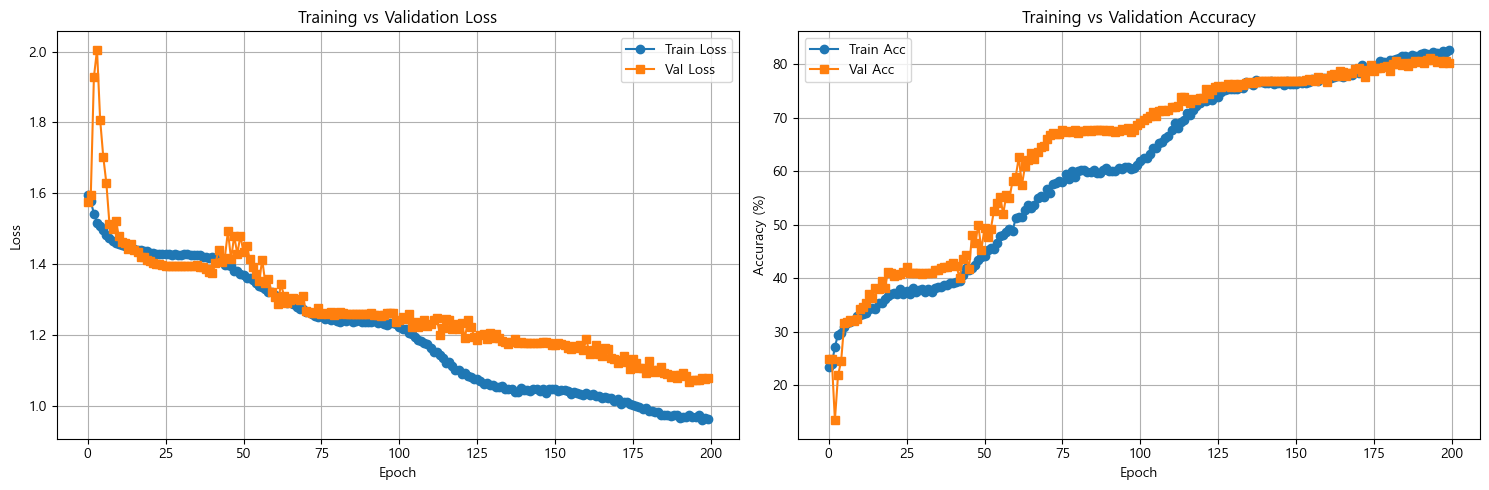

✓ Training history saved to 'training_history_classification_only.png'


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training vs Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('./Images/training_history_classification_only.png', dpi=300)
plt.show()

print("✓ Training history saved to 'training_history_classification_only.png'")

# 10. 개선된 Test Prediction & Submission

**포함 내용:**
- ✅ 올바른 submission.csv 형식 (idx: t_000, target: 0-4)
- ✅ 예측 분포 (클래스 이름 + 비율)
- ✅ F1 Score (Macro, Weighted, Per-Class)
- ✅ Classification Report
- ✅ Confusion Matrix

In [15]:
# 클래스 매핑
CLASS_NAMES = {
    0: '협박 대화',
    1: '갈취 대화',
    2: '기타 괴롭힘 대화',
    3: '직장 내 괴롭힘 대화',
    4: '일반 대화'
}

# ===========================================================================
# Step 1: Test Prediction
# ===========================================================================
print("="*70)
print("🎯 Test Prediction & Submission Generation")
print("="*70)

# Load best model
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"\n✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val Acc: {checkpoint['val_acc']:.2f}%")

# Test prediction
model.eval()
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        cls_logits = model(input_ids)
        _, predicted = torch.max(cls_logits, 1)
        predictions.extend(predicted.cpu().numpy())

# ===========================================================================
# Step 2: Create Submission (올바른 형식)
# ===========================================================================
print("\n" + "="*70)
print("📁 Submission File Generation")
print("="*70)

submission = pd.DataFrame({
    'idx': [f't_{i:03d}' for i in range(len(predictions))],
    'target': predictions
})

submission.to_csv(SUBMIT_PATH, index=False)
print(f"\n✓ Submission saved: submission.csv") 
print(f"  Format: idx (t_000, t_001, ...), target (0, 1, 2, 3, 4)")
print(f"  Total predictions: {len(predictions)}")

# ===========================================================================
# Step 3: Prediction Distribution
# ===========================================================================
print("\n" + "="*70)
print("📊 Prediction Distribution")
print("="*70)

pred_counts = Counter(predictions)

print("\n예측 결과 분포:")
print("-" * 70)
for label in sorted(pred_counts.keys()):
    class_name = CLASS_NAMES.get(label, f'Unknown({label})')
    count = pred_counts[label]
    percentage = count / len(predictions) * 100
    bar = '█' * int(percentage / 2)
    print(f"{label} {class_name:20s}: {count:3d} ({percentage:5.1f}%) {bar}")

print(f"\n총 예측 수: {len(predictions)}")

# Submission Preview
print("\n" + "="*70)
print("👀 Submission Preview (첫 10개)")
print("="*70)

preview_df = submission.head(10).copy()
preview_df['class'] = preview_df['target'].map(CLASS_NAMES)
print(preview_df.to_string(index=False))

# ===========================================================================
# Step 4: F1 Score Calculation
# ===========================================================================
print("\n" + "="*70)
print("📈 F1 Score Calculation (Validation Set)")
print("="*70)

# Validation prediction
val_predictions = []
val_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        cls_logits = model(input_ids)
        _, predicted = torch.max(cls_logits, 1)
        
        val_predictions.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Calculate F1 scores
f1_macro = f1_score(val_labels, val_predictions, average='macro')
f1_weighted = f1_score(val_labels, val_predictions, average='weighted')
f1_per_class = f1_score(val_labels, val_predictions, average=None, zero_division=0)

print(f"\n🎯 Overall F1 Scores:")
print(f"  Macro F1:    {f1_macro:.4f}")
print(f"  Weighted F1: {f1_weighted:.4f}")

print(f"\n🎯 Per-Class F1 Scores:")
print("-" * 70)
for i, score in enumerate(f1_per_class):
    if i < len(CLASS_NAMES):
        class_name = CLASS_NAMES[i]
        print(f"  {i} {class_name:20s}: {score:.4f}")

# ===========================================================================
# Step 5: Classification Report
# ===========================================================================
print("\n" + "="*70)
print("📋 Classification Report")
print("="*70)

unique_labels = sorted(set(val_labels))
target_names = [CLASS_NAMES.get(i, f'Class {i}') for i in unique_labels]

print("\n" + classification_report(
    val_labels, 
    val_predictions, 
    labels=unique_labels,
    target_names=target_names,
    digits=4,
    zero_division=0
))

# ===========================================================================
# Step 6: Confusion Matrix
# ===========================================================================
print("="*70)
print("🔢 Confusion Matrix")
print("="*70)

cm = confusion_matrix(val_labels, val_predictions)
print("\n행: 실제 (True), 열: 예측 (Predicted)\n")
print(" " * 8, end="")

for i in range(len(cm)):
    print(f"Pred{i:1d}", end="  ")
print()

for i, row in enumerate(cm):
    class_name = CLASS_NAMES.get(i, f'Class {i}')
    print(f"True{i} ", end="")
    for val in row:
        print(f"{val:5d}", end="  ")
    print(f" | {class_name}")

# ===========================================================================
# Step 7: Summary
# ===========================================================================
print("\n" + "="*70)
print("✨ Summary")
print("="*70)

print(f"\n📁 Submission:")
print(f"  ✓ File: submission.csv")
print(f"  ✓ Format: idx (t_XXX), target (0-4)")
print(f"  ✓ Total: {len(predictions)} predictions")

print(f"\n📊 Test Predictions:")
most_predicted = max(pred_counts, key=pred_counts.get)
print(f"  ✓ Most: {CLASS_NAMES[most_predicted]} ({pred_counts[most_predicted]}회)")

print(f"\n📈 Validation Performance:")
print(f"  ✓ Macro F1:    {f1_macro:.4f}")
print(f"  ✓ Weighted F1: {f1_weighted:.4f}")
print(f"  ✓ Accuracy:    {checkpoint['val_acc']:.2f}%")

print(f"\n🎯 Best Class: {CLASS_NAMES[np.argmax(f1_per_class)]} (F1: {np.max(f1_per_class):.4f})")
print(f"⚠️  Worst Class: {CLASS_NAMES[np.argmin(f1_per_class)]} (F1: {np.min(f1_per_class):.4f})")

print("\n" + "="*70)
print("✅ All Done!")
print("="*70)

🎯 Test Prediction & Submission Generation

✓ Loaded best model from epoch 194
  Val Loss: 1.0676
  Val Acc: 81.25%


Predicting: 100%|██████████| 16/16 [00:00<00:00, 210.96it/s]



📁 Submission File Generation

✓ Submission saved: submission.csv
  Format: idx (t_000, t_001, ...), target (0, 1, 2, 3, 4)
  Total predictions: 500

📊 Prediction Distribution

예측 결과 분포:
----------------------------------------------------------------------
0 협박 대화               : 102 ( 20.4%) ██████████
1 갈취 대화               : 141 ( 28.2%) ██████████████
2 기타 괴롭힘 대화           : 157 ( 31.4%) ███████████████
3 직장 내 괴롭힘 대화         :  85 ( 17.0%) ████████
4 일반 대화               :  15 (  3.0%) █

총 예측 수: 500

👀 Submission Preview (첫 10개)
  idx  target       class
t_000       1       갈취 대화
t_001       2   기타 괴롭힘 대화
t_002       2   기타 괴롭힘 대화
t_003       4       일반 대화
t_004       3 직장 내 괴롭힘 대화
t_005       0       협박 대화
t_006       0       협박 대화
t_007       1       갈취 대화
t_008       2   기타 괴롭힘 대화
t_009       1       갈취 대화

📈 F1 Score Calculation (Validation Set)


Validating: 100%|██████████| 41/41 [00:00<00:00, 197.84it/s]


🎯 Overall F1 Scores:
  Macro F1:    0.8319
  Weighted F1: 0.8090

🎯 Per-Class F1 Scores:
----------------------------------------------------------------------
  0 협박 대화               : 0.7789
  1 갈취 대화               : 0.8213
  2 기타 괴롭힘 대화           : 0.8418
  3 직장 내 괴롭힘 대화         : 0.7372
  4 일반 대화               : 0.9802

📋 Classification Report

              precision    recall  f1-score   support

       협박 대화     0.7992    0.7595    0.7789       262
       갈취 대화     0.7658    0.8854    0.8213       314
   기타 괴롭힘 대화     0.7733    0.9236    0.8418       288
 직장 내 괴롭힘 대화     0.8821    0.6332    0.7372       319
       일반 대화     0.9900    0.9706    0.9802       102

    accuracy                         0.8125      1285
   macro avg     0.8421    0.8345    0.8319      1285
weighted avg     0.8210    0.8125    0.8090      1285

🔢 Confusion Matrix

행: 실제 (True), 열: 예측 (Predicted)

        Pred0  Pred1  Pred2  Pred3  Pred4  
True0   199     31     20     11      1   | 협박 대화
True1    22 

## 🎯 Summary

### ✅ Changes Made (FIXED VERSION):
1. ✅ **Removed Language Modeling Head** - No more `prediction_head` / `lm_head`
2. ✅ **Classification Loss Only** - Single-task learning (no LM loss)
3. ✅ **Fixed collate_fn** - Proper padding for variable-length sequences
4. ✅ **Data Augmentation** - 일반 대화(4) 제외, 나머지 증강
5. ✅ **Improved Submission** - F1 scores + prediction distribution

### Model Architecture:
- **Backbone**: GPT-1 Decoder (12 layers, 768d, 12 heads)
- **Head**: Classification head only (768 → 5 classes)
- **Training**: Classification loss with label smoothing (0.1)

### Data Strategy:
- **Augmentation**: 3x for classes 0,1,2,3 (exclude class 4)
- **Train/Val Split**: 80/20
- **Batch Size**: 32

### Performance Tracking:
- Loss curves (train/val)
- Classification metrics (F1, precision, recall)
- Confusion matrix
- Per-class F1 scores
